In [ ]:
pip install d2l==1.0.0b0

In [21]:
import torch
from torch import nn
from d2l import torch as d2l
from torch import tensor

# Results from lecture

In [22]:
class Module(d2l.nn_Module, d2l.HyperParameters):
    """Defined in :numref:`sec_oo-design`"""
    def __init__(self, plot_train_per_epoch=3, plot_valid_per_epoch=2):
        super().__init__()
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

In [23]:
def init_cnn(module): 
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class Classifier(Module):
    """Defined in :numref:`sec_classification`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=True)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.
    
        Defined in :numref:`sec_classification`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        return d2l.reduce_mean(compare) if averaged else compare
        

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return d2l.F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

class LeNet(Classifier):  
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))


In [24]:
@d2l.add_to_class(Classifier)  
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet() 
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


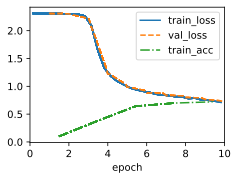

In [25]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

# Question 1 part part 1

Replacing the average pooling with max-pooling.

In [26]:
class LeNet_max_pool(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

model_max_pool = LeNet_max_pool() 
model_max_pool.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


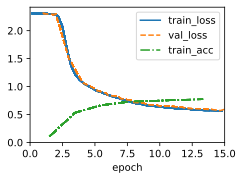

In [27]:
trainer_max_pool = d2l.Trainer(max_epochs=15, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_max_pool.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer_max_pool.fit(model_max_pool, data)

# Question 1 part part b

Replace the softmax layer with ReLU.

In [28]:
# Since Sigmoid() is a extenstion function of the Softmax, this can be replaced with nn.ReLU

class LeNet_ReLU(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
model_ReLU = LeNet_ReLU() 
model_ReLU.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


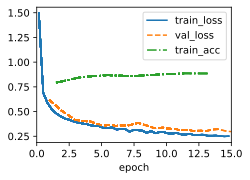

In [29]:
trainer_ReLU = d2l.Trainer(max_epochs=15, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_ReLU.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer_ReLU.fit(model_ReLU, data)

# Question 2


Part 1: Adjust the convolution window size.

In [30]:
class LeNet_window(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=10, padding=2), nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=10), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
model_window = LeNet_window() 
model_window.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 23, 23])
Sigmoid output shape:	 torch.Size([1, 6, 23, 23])
AvgPool2d output shape:	 torch.Size([1, 6, 11, 11])
Conv2d output shape:	 torch.Size([1, 16, 2, 2])
Sigmoid output shape:	 torch.Size([1, 16, 2, 2])
AvgPool2d output shape:	 torch.Size([1, 16, 1, 1])
Flatten output shape:	 torch.Size([1, 16])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


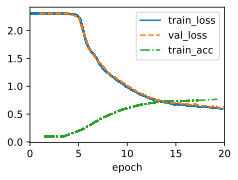

In [31]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_window.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_window, data)

part 2: Adjust the number of output channels (width of each layer).

In [32]:
class LeNet_channels(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(15, kernel_size=5, padding=2), nn.Sigmoid(), # Window size/kernal size changed form 6 to 15
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(30, kernel_size=5), nn.Sigmoid(), #  Window size/kernal size changed from 16 to 30
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
model_channels = LeNet_channels() 
model_channels.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 15, 28, 28])
Sigmoid output shape:	 torch.Size([1, 15, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 15, 14, 14])
Conv2d output shape:	 torch.Size([1, 30, 10, 10])
Sigmoid output shape:	 torch.Size([1, 30, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 30, 5, 5])
Flatten output shape:	 torch.Size([1, 750])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


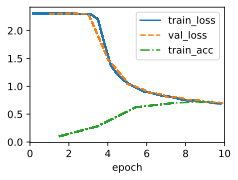

In [33]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_channels.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_channels, data)

3. Adding convolutional Layers

In [41]:
class LeNet_extra_layer(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(24, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

model_exta_layer = LeNet_extra_layer() 
model_exta_layer.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 14, 14])
Sigmoid output shape:	 torch.Size([1, 16, 14, 14])
AvgPool2d output shape:	 torch.Size([1, 16, 7, 7])
Conv2d output shape:	 torch.Size([1, 24, 3, 3])
Sigmoid output shape:	 torch.Size([1, 24, 3, 3])
AvgPool2d output shape:	 torch.Size([1, 24, 1, 1])
Flatten output shape:	 torch.Size([1, 24])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


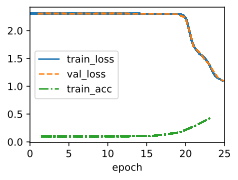

In [42]:
trainer = d2l.Trainer(max_epochs=25, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_exta_layer.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_exta_layer, data)

4. Adding a fully connected layer

In [43]:
class LeNet_fullyConnected(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(256), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

model_fullyConnected = LeNet_fullyConnected() 
model_fullyConnected.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 14, 14])
Sigmoid output shape:	 torch.Size([1, 16, 14, 14])
AvgPool2d output shape:	 torch.Size([1, 16, 7, 7])
Flatten output shape:	 torch.Size([1, 784])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 256])
Sigmoid output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 10])


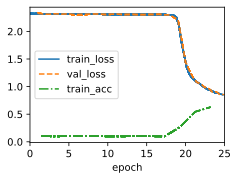

In [44]:
trainer = d2l.Trainer(max_epochs=25, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_fullyConnected.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_fullyConnected, data)

5. Explore the learning rates.


In [45]:
class LeNet_lr(Classifier):  
    """The LeNet-5 model."""
    def __init__(self, lr=0.05, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
model_lr = LeNet() 
model_lr.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


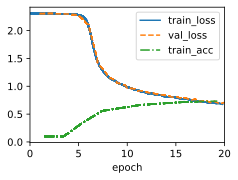

In [46]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_lr = LeNet_lr(lr=0.05)
model_lr.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_lr, data)

# Question 3:


Appling dropout to LeNet-5 across all experiments in problem 2

In [55]:
class LeNet_window2(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=10, padding=2), nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=10), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),nn.Dropout2d(p=0.3),
            nn.LazyLinear(84), nn.Sigmoid(),nn.Dropout2d(p=0.3),
            nn.LazyLinear(num_classes))
model_window2 = LeNet_window2() 
model_window2.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 23, 23])
Sigmoid output shape:	 torch.Size([1, 6, 23, 23])
AvgPool2d output shape:	 torch.Size([1, 6, 11, 11])
Conv2d output shape:	 torch.Size([1, 16, 2, 2])
Sigmoid output shape:	 torch.Size([1, 16, 2, 2])
AvgPool2d output shape:	 torch.Size([1, 16, 1, 1])
Flatten output shape:	 torch.Size([1, 16])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Dropout2d output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Dropout2d output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


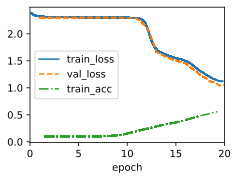

In [56]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_window2.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_window2, data)

In [67]:
class LeNet_channels2(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(15, kernel_size=5, padding=2), nn.ReLU(), # Window size/kernal size changed form 6 to 15
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(30, kernel_size=5), nn.ReLU(), #  Window size/kernal size changed from 16 to 30
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),nn.Dropout2d(p=0.5),
            nn.LazyLinear(84), nn.ReLU(),nn.Dropout2d(p=0.5),
            nn.LazyLinear(num_classes))
model_channels2 = LeNet_channels2() 
model_channels2.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 15, 28, 28])
ReLU output shape:	 torch.Size([1, 15, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 15, 14, 14])
Conv2d output shape:	 torch.Size([1, 30, 10, 10])
ReLU output shape:	 torch.Size([1, 30, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 30, 5, 5])
Flatten output shape:	 torch.Size([1, 750])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout2d output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout2d output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


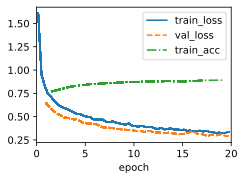

In [68]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_channels2.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_channels2, data)

In [69]:
class LeNet_extra_layer2(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(24, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),nn.Dropout2d(p=0.3),
            nn.LazyLinear(84), nn.ReLU(),nn.Dropout2d(p=0.3),
            nn.LazyLinear(num_classes))

model_exta_layer2 = LeNet_extra_layer2() 
model_exta_layer2.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 14, 14])
ReLU output shape:	 torch.Size([1, 16, 14, 14])
AvgPool2d output shape:	 torch.Size([1, 16, 7, 7])
Conv2d output shape:	 torch.Size([1, 24, 3, 3])
ReLU output shape:	 torch.Size([1, 24, 3, 3])
AvgPool2d output shape:	 torch.Size([1, 24, 1, 1])
Flatten output shape:	 torch.Size([1, 24])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout2d output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout2d output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


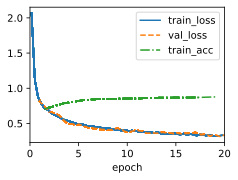

In [70]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_exta_layer2.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_exta_layer2, data)

In [71]:
class LeNet_fullyConnected2(Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),nn.Dropout2d(p=0.5),
            nn.LazyLinear(84), nn.ReLU(),nn.Dropout2d(p=0.5),
            nn.LazyLinear(256), nn.ReLU(),nn.Dropout2d(p=0.5),
            nn.LazyLinear(num_classes))

model_fullyConnected2 = LeNet_fullyConnected2() 
model_fullyConnected2.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 14, 14])
ReLU output shape:	 torch.Size([1, 16, 14, 14])
AvgPool2d output shape:	 torch.Size([1, 16, 7, 7])
Flatten output shape:	 torch.Size([1, 784])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout2d output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout2d output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Dropout2d output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 10])


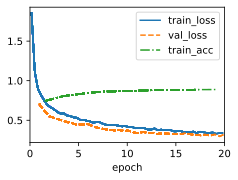

In [72]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_fullyConnected2.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_fullyConnected2, data)

In [73]:
class LeNet_lr2(Classifier):  
    """The LeNet-5 model."""
    def __init__(self, lr=0.05, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),nn.Dropout2d(p=0.5),
            nn.LazyLinear(84), nn.ReLU(),nn.Dropout2d(p=0.5),
            nn.LazyLinear(num_classes))
model_lr2 = LeNet_lr2() 
model_lr2.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout2d output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout2d output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


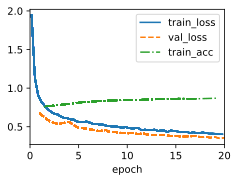

In [74]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model_lr2.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_lr2, data)

#Question 4:

Simplifying the model to make the training faster while ensuring that the accuracy stays relatively high

In [87]:
class AlexNet(Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

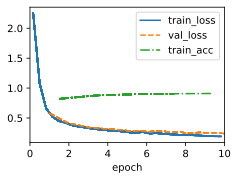

In [88]:
# Base AlexNet graph
model_alex = AlexNet(lr=0.1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model_alex, data)

In [89]:
class AlexNetUpdated(Classifier):
    def __init__(self, lr=0.05, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=4, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),
            nn.LazyConv2d(256, kernel_size=4, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.LazyConv2d(384, kernel_size=4, padding=2), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=4, padding=2), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=4, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.4),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.4),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

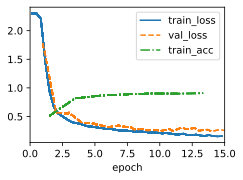

In [90]:
model_alex_updated = AlexNetUpdated(lr=0.1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
trainer.fit(model_alex_updated, data)